目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。 为了快速测试目标检测模型，我们收集并标记了一个小型数据集。 首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。 然后，我们在一些背景图片的随机位置上放一张香蕉的图像。 最后，我们在图片上为这些香蕉标记了边界框。

# 下载数据集
包含所有图像和CSV标签文件的香蕉检测数据集可以直接从互联网下载。

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

# 读取数据集
通过`read_data_bananas`函数，我们读取香蕉检测数据集。 该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。

In [2]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

通过使用read_data_bananas函数读取图像和标签，以下BananasDataset类别将允许我们创建一个自定义Dataset实例来加载香蕉检测数据集。

In [3]:
#@save
class BananaDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if is_train else f' validation examples'))
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，无须按随机顺序读取它。

In [4]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(is_train=False), batch_size)
    return train_iter, val_iter

In [5]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

正在从http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip下载..\Datasets\banana-detection.zip...
read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

# 演示

AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

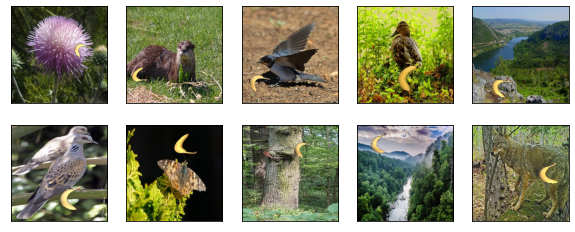

In [6]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# 小结
+ 我们收集的香蕉检测数据集可用于演示目标检测模型。

+ 用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。